# Glider data worflow from raw

****

# Convert binary files

In [1]:
#Simply change the working directory to the project directory

import os

current_dir = os.getcwd()
parent_parent_dir = os.path.dirname(current_dir)
os.chdir(parent_parent_dir)

# Now the working directory is set to the project directory
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\flapet\OneDrive - NOC\Documents\IDAPro\lib\db_building


In [4]:
import zipfile
# Unzip the raw data downloaded from BODC
zip_file_path = 'data/glider/raw/538.zip'

# Specify the directory where you want to extract the contents
extract_dir = 'data/glider/raw/538_unzip'

# Create the directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the specified directory
    zip_ref.extractall(extract_dir)

Move the .calc txt files to a dedicated directory for the library to find them

In [10]:
import glob
import shutil


source_folder = 'data/glider/raw/538_unzip/'
destination_folder = 'data/glider/raw/538_unzip/cac/'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Find all *.calc files in the source folder
calc_files = glob.glob(os.path.join(source_folder, '*.cac'))

# Move each *.calc file to the destination folder
for calc_file in calc_files:
    shutil.move(calc_file, destination_folder)

****

## Creation of the yaml file for metadata

In [7]:
#copy the deployment yaml file templte to my raw glider folder
source_file = 'data/glider/raw/deployment.yml'
destination_dir = 'data/glider/raw/538_unzip/deployment_538.yml'

shutil.copy(source_file, destination_dir)

'data/glider/raw/538_unzip/deployment_538.yml'

**Open the yaml file and edit it manually with metadat from the glider deployment**

****

## Edition of sensors filter list

In [8]:
#Copy the sensor list template
source_file = 'data/glider/raw/slocum_sensor_template.txt'
destination_dir = 'data/glider/raw/538_unzip/sensors_538.txt'

shutil.copy(source_file, destination_dir)

'data/glider/raw/538_unzip/sensors_538.txt'

**Open the txt file and modify it maunaully**

****

## Try to run process_deploymentRealtime

INFO:pyglider.slocum:data/glider/raw/538_unzip//*.[s|t]bd
INFO:dbdreader.py:No valid data to interpolate for 'sci_oxy4_saturation'.
INFO:pyglider.slocum:working on latitude
INFO:pyglider.slocum:names: latitude m_lat
INFO:pyglider.slocum:working on longitude
INFO:pyglider.slocum:names: longitude m_lon
INFO:pyglider.slocum:working on heading
INFO:pyglider.slocum:names: heading m_heading
INFO:pyglider.slocum:working on pitch
INFO:pyglider.slocum:names: pitch m_pitch
INFO:pyglider.slocum:working on roll
INFO:pyglider.slocum:names: roll m_roll
INFO:pyglider.slocum:working on waypoint_latitude
INFO:pyglider.slocum:names: waypoint_latitude c_wpt_lat
INFO:pyglider.slocum:working on waypoint_longitude
INFO:pyglider.slocum:names: waypoint_longitude c_wpt_lon
INFO:pyglider.slocum:working on conductivity
INFO:pyglider.slocum:names: conductivity sci_water_cond
INFO:pyglider.slocum:working on temperature
INFO:pyglider.slocum:names: temperature sci_water_temp
INFO:pyglider.slocum:working on pressure


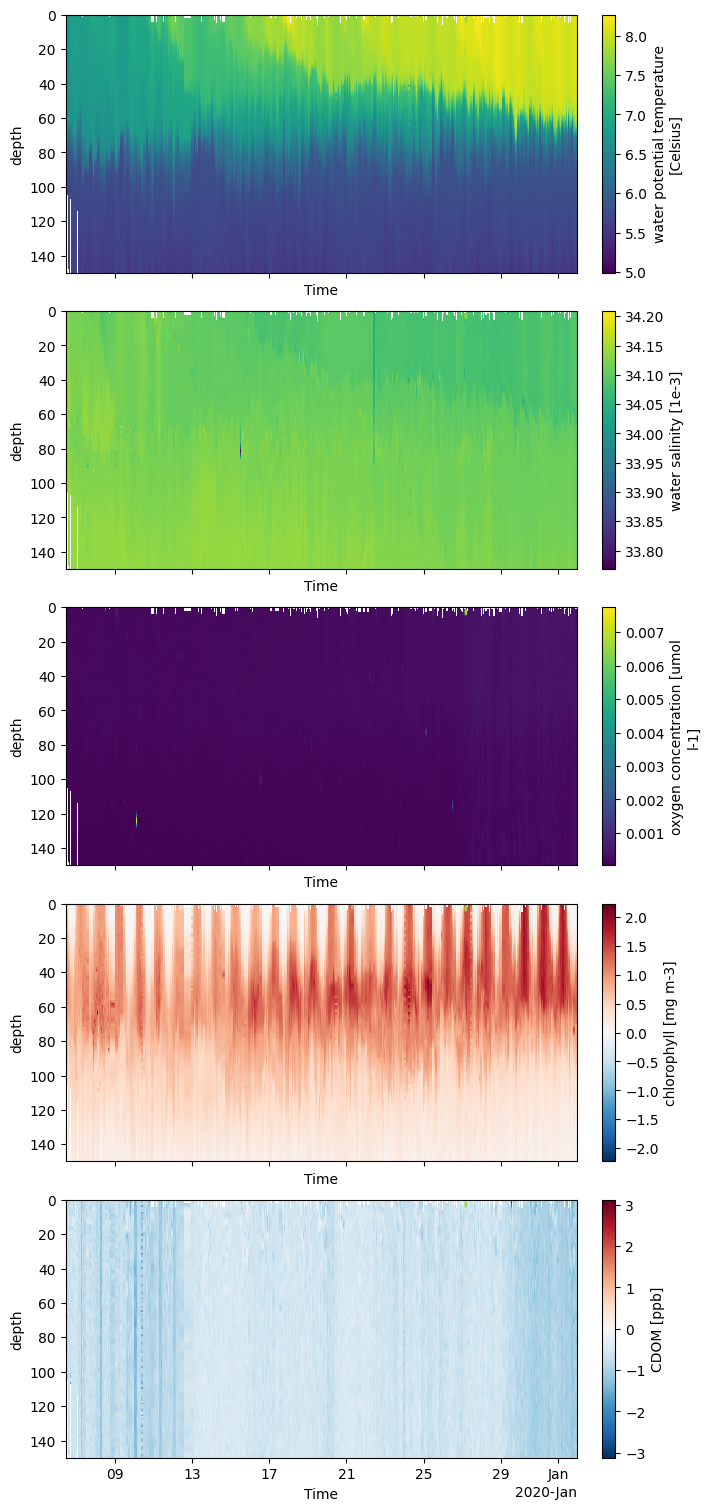

In [2]:
import logging
import pyglider.ncprocess as ncprocess
import pyglider.slocum as slocum
import pyglider.utils as pgutils
import dbdreader

logging.basicConfig(level='INFO')

binarydir = 'data/glider/raw/538_unzip/'
rawdir = 'data/glider/raw/538_nc/'
cacdir = binarydir + 'cac/'
sensorlist = binarydir + 'sensors_538.txt'
deploymentyaml = binarydir + 'deployment_538.yml'
l1tsdir = binarydir + 'L0-timeseries/'
profiledir = binarydir + 'L0-profiles/'
griddir = binarydir + 'L0-gridfiles/'
scisuffix = 'tbd'
glidersuffix = 'sbd'

do_direct = True
# only do this for a real run, or something like this
real = False
if real:
    os.system('rsync -av cproof@sfmc.webbresearch.com:/var/opt/sfmc-dockserver/' +
              'stations/dfo/gliders/ ~/gliderdata/slocum_dockserver/')
    os.system('rsync -av ~/gliderdata/slocum_dockserver/rosie_713/from-glider/* ' +
              binarydir)

    os.system('rm ' + rawdir + 'dfo* ' + rawdir + 'TEMP*.nc ' + l1tsdir + '* ' +
              profiledir + '* ' + griddir + '* ')

if do_direct:
    # turn *.sdb and *.tbd into timeseries netcdf files
    outname = slocum.binary_to_timeseries(
        binarydir, cacdir, l1tsdir, deploymentyaml, search='*.[s|t]bd',
        profile_filt_time=20, profile_min_time=20)
else:
    # turn *.EBD and *.DBD into *.ebd.nc and *.dbd.nc netcdf files.
    slocum.binary_to_rawnc(
        binarydir, rawdir, cacdir, sensorlist, deploymentyaml,
        incremental=True, scisuffix=scisuffix, glidersuffix=glidersuffix)

    # merge individual neetcdf files into single netcdf files *.ebd.nc and *.dbd.nc
    slocum.merge_rawnc(
        rawdir, rawdir, deploymentyaml,
        scisuffix=scisuffix, glidersuffix=glidersuffix)

    # Make level-1 timeseries netcdf file from th raw files...
    outname = slocum.raw_to_timeseries(
        rawdir, l1tsdir, deploymentyaml,
        profile_filt_time=100, profile_min_time=300)

if False:
    # make profile netcdf files for ioos gdac...
    ncprocess.extract_timeseries_profiles(outname, profiledir, deploymentyaml)

# make grid of dataset....

outname2 = ncprocess.make_gridfiles(outname, griddir, deploymentyaml)
pgutils.example_gridplot(outname2, './gridplot2.png', ylim=[150, 0],
                         toplot=['potential_temperature', 'salinity',
                                 'oxygen_concentration', 'chlorophyll', 'cdom'])